In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, average_precision_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.feature_selection import SelectFromModel, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Importing models
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Function for printing ROC and f1 score
def print_results(ytest, ypred, ypredproba):
    roc = roc_auc_score(ytest, ypredproba[:,1], average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    print('[ Metrics Evaluation ]\n')
    print('ROC Auc:    {}'.format(roc))
    print('f1 Score:     {}'.format(f1))
    print(('Classification Report:\n{}'.format(classification_report(ytest, ypred))))
    return roc, f1

In [3]:
# Input all the features after filtering from pearsonr to x and y
# Read csv that has been sampled, clean data
df = pd.read_csv('ageGroup.csv')
df = df.drop('communication_onlinerate', axis=1) # Cannot infer from this feature
df = df.drop('uid', axis=1) # Cannot infer from this feature
df[df < 0] = 0 # Change all negative values to 0

x = df.loc[:, ['tags', 'device_size', 'career', 'up_life_duration', 'indu_name', 'age', 'gender']]
y = df["label"]
y = LabelEncoder().fit_transform(y)

# Split data into training and testing data, and make sure it is stratified (ratio maintained)
cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

# Use SMOTE for data oversampling
over = SMOTE()
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)

[44655 22573 19653 47575]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.7691420588631821
f1 Score:     0.6858011198857171
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68     67228
           1       0.68      0.71      0.69     67228

    accuracy                           0.69    134456
   macro avg       0.69      0.69      0.69    134456
weighted avg       0.69      0.69      0.69    134456



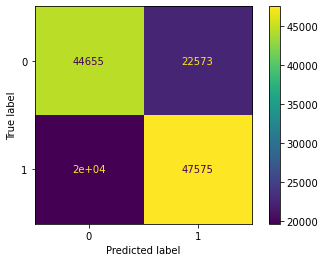

In [4]:
# LGBM
# Use LGBM Classifier and find the result of the prediction and prediction probability
# When both train and test data are oversampled
lgbm = LGBMClassifier(application='binary', max_depth=-10, metrics = 'auc').fit(x_train_oversample, y_train_oversample)
y_pred = lgbm.predict(x_test_oversample)
y_predproba = lgbm.predict_proba(x_test_oversample)

# Printing the metrics evaluation
# TN, FP, FN, TP
print(confusion_matrix(y_test_oversample, y_pred).ravel())
plot_confusion_matrix(lgbm, x_test_oversample, y_test_oversample)
roc_lgbm_over, f1_lgbm_over = print_results(y_test_oversample, y_pred, y_predproba)

In [5]:
# LightGBM (oversample train & test data)

lgbm_params = {
    'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = lgbm.predict(x_test_oversample)
y_predproba_oversample = lgbm.predict_proba(x_test_oversample)      

roc_lgbm_oversample_1, f1_lgbm_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.76398628203351
f1 Score:     0.685079330582813
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68     67228
           1       0.68      0.70      0.69     67228

    accuracy                           0.69    134456
   macro avg       0.69      0.69      0.69    134456
weighted avg       0.69      0.69      0.69    134456

[44932 22296 20035 47193]


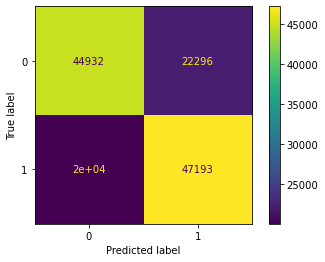

In [6]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [7]:
# LightGBM Classifier (oversample train data)

lgbm_params = {
    'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)


y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)      

roc_lgbm_1, f1_lgbm_1 = print_results(y_test,y_pred, y_predproba) 
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6089758486787997
f1 Score:     0.764241330654987
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     67228
           1       0.06      0.50      0.10      2772

    accuracy                           0.66     70000
   macro avg       0.51      0.58      0.45     70000
weighted avg       0.93      0.66      0.76     70000

[44932 22296  1386  1386]


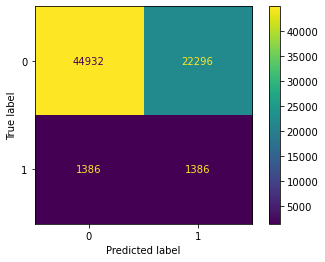

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [9]:
# xgboost classifier (oversample train & test set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = xgbc.predict(x_test_oversample)
y_predproba_oversample = xgbc.predict_proba(x_test_oversample)      

roc_xgb_oversample_1, f1_xgb_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.775482297322446
f1 Score:     0.6924483344422572
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     67228
           1       0.69      0.71      0.70     67228

    accuracy                           0.69    134456
   macro avg       0.69      0.69      0.69    134456
weighted avg       0.69      0.69      0.69    134456

[45272 21956 19381 47847]


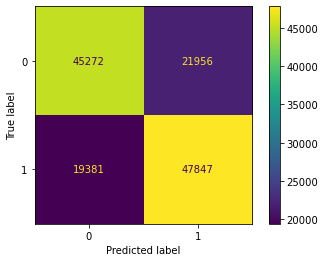

In [10]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [11]:
# xgboost classifier

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred = xgbc.predict(x_test)
y_predproba = xgbc.predict_proba(x_test)      

roc_xgb_1, f1_xgb_1 = print_results(y_test,y_pred, y_predproba)
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6164009135074018
f1 Score:     0.767846767105059
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.80     67228
           1       0.06      0.50      0.11      2772

    accuracy                           0.67     70000
   macro avg       0.52      0.59      0.45     70000
weighted avg       0.93      0.67      0.77     70000

[45272 21956  1377  1395]


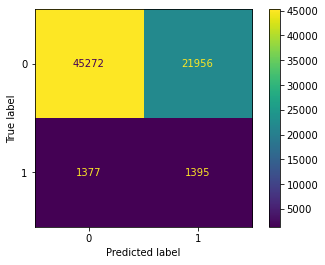

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [13]:
# Decision Tree Classifier (oversample train & test set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = dtc.predict(x_test_oversample)
y_predproba_oversample = dtc.predict_proba(x_test_oversample)         

roc_dtc_oversample_1, f1_dtc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6907918854290487
f1 Score:     0.6396657267947787
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65     67228
           1       0.65      0.62      0.63     67228

    accuracy                           0.64    134456
   macro avg       0.64      0.64      0.64    134456
weighted avg       0.64      0.64      0.64    134456

[44348 22880 25550 41678]


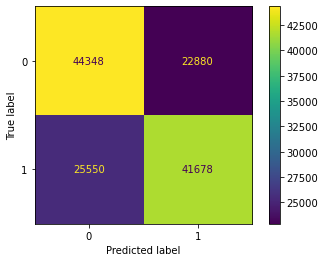

In [14]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [15]:
# Decision Tree Classifier (oversample train set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)      

roc_dtc_1, f1_dtc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.5836057795955457
f1 Score:     0.7573673390375603
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     67228
           1       0.05      0.47      0.10      2772

    accuracy                           0.65     70000
   macro avg       0.51      0.57      0.44     70000
weighted avg       0.93      0.65      0.76     70000

[44340 22888  1460  1312]


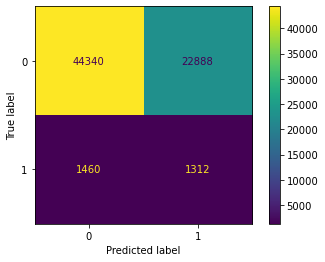

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [17]:
# Random Forest Classifier (oversample train & test set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = rfc.predict(x_test_oversample)
y_predproba_oversample = rfc.predict_proba(x_test_oversample)      

roc_rfc_oversample_1, f1_rfc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6952552644267251
f1 Score:     0.6356254393442136
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     67228
           1       0.64      0.61      0.63     67228

    accuracy                           0.64    134456
   macro avg       0.64      0.64      0.64    134456
weighted avg       0.64      0.64      0.64    134456

[44448 22780 26181 41047]


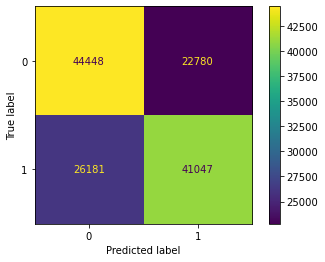

In [18]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

In [19]:
# Random Forest Classifier (oversample train set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)      

roc_rfc_1, f1_rfc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.582024668846752
f1 Score:     0.7590290871116389
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79     67228
           1       0.05      0.47      0.10      2772

    accuracy                           0.65     70000
   macro avg       0.51      0.57      0.44     70000
weighted avg       0.93      0.65      0.76     70000

[44508 22720  1470  1302]


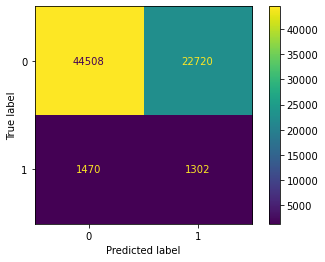

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

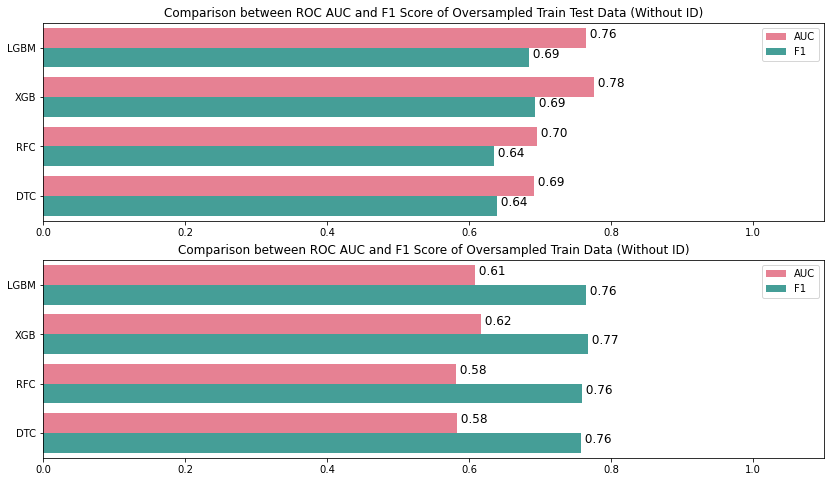

<Figure size 720x360 with 0 Axes>

In [21]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Train Test Data

fig, axs = plt.subplots(nrows=2, figsize=(14,8))

labelArr = np.array(['AUC', 'AUC', 'AUC', 'AUC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_oversample_1, roc_xgb_oversample_1, roc_rfc_oversample_1, roc_dtc_oversample_1, f1_lgbm_oversample_1, f1_xgb_oversample_1, f1_rfc_oversample_1, f1_dtc_oversample_1])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

metricsArr2 = np.array([roc_lgbm_1, roc_xgb_1, roc_rfc_1, roc_dtc_1, f1_lgbm_1, f1_xgb_1, f1_rfc_1, f1_dtc_1])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl', ax=axs[0])
bar2 = sns.barplot(metricsArr2, xArr, hue=labelArr, palette='husl', ax=axs[1])
axs[0].set(xlim = (None, 1.1))
axs[1].set(xlim = (None, 1.1))
axs[0].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Test Data (Without ID)')
axs[1].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Data (Without ID)')
# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)
    
for p in bar2.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar2.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12) 